In [2]:
# metrics
# [clean accuracy, robust accuracy, top-k mask overlap under pertubed]

# vit model
# deit, vit

# dataset
# cifar10, lsun_bedroom, lsun_cat, lsun_church

# threat method

In [2]:
import timm
import torch
from torch import nn
net = timm.create_model("vit_base_patch16_384", pretrained=True)
net.head = nn.Linear(net.head.in_features, 10)
# module problem
state_dict = torch.load("/home/yila22/prj/vision-transformers-cifar10/checkpoint/vit_timm-4-ckpt.t7", map_location="cpu")["model"]
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v
net.load_state_dict(new_state_dict)
from ut import *
device = 'cuda:2'
net = net.to(device)

/home/yila22/anaconda3/envs/smooth-vit/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
stty: 'standard input': Inappropriate ioctl for device


In [3]:
import torchvision
from torchvision import transforms
import torch
# model = torch.hub.load('facebookresearch/deit:main', 
# 'deit_tiny_patch16_224', pretrained=True)

# normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
transform_test = transforms.Compose([
    transforms.Resize(384),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified


In [4]:
model = net

In [5]:

# Loss is CE
from torch import nn
criterion = nn.CrossEntropyLoss()

##### Validation
def test():
    # global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            # outputs = net(inputs)
            # inputs = [inputs[i] for i in range(inputs.shape[0])]
            # inputs = feature_extractor(images=inputs, return_tensors="pt")
            # inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
    
    # Save checkpoint.
    acc = 100.*correct/total
    return test_loss, acc

In [18]:
test()

 [================================================================>]  Step: 51ms | Tot: 2m6s | Loss: 0.052 | Acc: 98.590% (9859/1000 2500/2500 0  ............................................................]  Step: 50ms | Tot: 2s589ms | Loss: 0.122 | Acc: 96.698% (205/21 53/2500 ====>............................................................]  Step: 49ms | Tot: 8s633ms | Loss: 0.048 | Acc: 98.563% (686/69 174/2500 ============>....................................................]  Step: 50ms | Tot: 23s320ms | Loss: 0.036 | Acc: 98.825% (1850/187 468/2500 =============>...................................................]  Step: 50ms | Tot: 25s675ms | Loss: 0.042 | Acc: 98.689% (2033/206 515/2500 =============>...................................................]  Step: 50ms | Tot: 26s379ms | Loss: 0.041 | Acc: 98.724% (2089/211 529/2500 ==============>..................................................]  Step: 50ms | Tot: 27s133ms | Loss: 0.040 | Acc: 98.759% (2149/217 544/2500 ========

(130.23740289782563, 98.59)

In [ ]:
# clean case

# get model
# get dataset
# loop over dataset
# get metrics: clean accuracy

In [6]:
class Averager(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [7]:
from tqdm import tqdm

In [11]:
import numpy as np
# poisoning case without defense

# get model
# get dataset  
# loop over dataset
net.eval()
test_loss = 0
adv_test_loss=0
correct = 0
correct_adv = 0
total = 0

from vit_rollout import VITAttentionRollout
rollout = VITAttentionRollout(model, discard_ratio=0.9, head_fusion='max')
masks = []
masks_after_poison = []
topk_index_orignal = []
topk_index_after = []
topk_overlap = []
topk_overlap_value = Averager()
robust_acc = 0  
import torchattacks
torch.backends.cudnn.deterministic = True
atk = torchattacks.PGD(model, eps=4/255, alpha=2/255, steps=5)
atk.set_normalization_used(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
# 
for batch_idx, (inputs, targets) in tqdm(enumerate(testloader)):
    if total > 100:
        break
    with torch.no_grad():
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            # % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        # print("clean accuracy: ", 100.*correct/total)

        # get the original attention mask
        images_to_list = [inputs[i] for i in range(inputs.shape[0])]
        
        for image in images_to_list:
            image = image.unsqueeze(0)
            attention_mask = rollout(image)
            masks.append(attention_mask)
    
    # poison the data with Adversarial Attack
    inputs, targets = inputs.to(device), targets.to(device)
    
    adv_images = atk(inputs, targets)
    
    
    # get the attention mask after poisoning
    with torch.no_grad():
        adv_images_to_list = [adv_images[i] for i in range(inputs.shape[0])]
        
        for adv_image_i in adv_images_to_list:
            adv_image_i = adv_image_i.unsqueeze(0)
            attention_mask_after = rollout(adv_image_i)
            masks_after_poison.append(attention_mask_after)

    # get the metrics: robust accuracy,
    with torch.no_grad():
        
        adv_images, targets = adv_images.to(device), targets.to(device)
        outputs_after = model(adv_images)
        adv_loss = criterion(outputs_after, targets)

        adv_test_loss += adv_loss.item()
        _, predicted = outputs_after.max(1)
        total += targets.size(0)
        correct_adv += predicted.eq(targets).sum().item()
        # print("robust accuracy: ", 100.*correct_adv/total)
        robust_acc = 100.*correct_adv/total
    
    #  top-k mask overlap under pertubed
    K = 5
    bs = inputs.shape[0]
    mask_original = np.concatenate(masks[-bs:], axis=0)
    mask_after_poison = np.concatenate(masks_after_poison[-bs:], axis=0)
    mask_original = mask_original.reshape(bs, -1)
    mask_after_poison = mask_after_poison.reshape(bs,-1)
    mask_after_poison = torch.tensor(mask_after_poison)
    mask_original = torch.tensor(mask_original)
    topk_index_orignal.append(torch.topk(mask_original, k=K, dim=1).indices)
    topk_index_after.append(torch.topk(mask_after_poison, k=K, dim=1).indices)
    topk_overlap.append(torch.mean((torch.sum(topk_index_orignal[-1] == topk_index_after[-1], dim=1).float())/K).item())
    
    # print("top-k mask overlap under pertubed: ", topk_overlap[-1])
    topk_overlap_value.update(topk_overlap[-1], bs)
    
    # break
print("final robust accuracy: ", robust_acc)
print("final top-k mask overlap under pertubed: ", topk_overlap_value.avg)

13it [01:46,  8.19s/it]

final robust accuracy:  0.0
final top-k mask overlap under pertubed:  0.2153846174478531


In [8]:
# poisoning case with defense

# get model
# get dataset  
# loop over dataset
# for data inside the poison set
# get the original attention mask
# poison the data with Adversarial Attack with epsilon
# 1. denoise poisoned image with pretrained diffusion model with epsilon
# 2. conduct random smoothing on the denoised image with delta of R computed using (2*delta ?)
# get the attention mask after poisoning
# get the metrics: robust accuracy, top-k mask overlap under pertubed


import numpy as np
# poisoning case without defense

# get model
# get dataset  
# loop over dataset
net.eval()
test_loss = 0
adv_test_loss=0
correct = 0
correct_adv = 0
total = 0

from vit_rollout import VITAttentionRollout
rollout = VITAttentionRollout(model, discard_ratio=0.9, head_fusion='max')
masks = []
masks_after_poison = []
topk_index_orignal = []
topk_index_after = []
topk_overlap = []
topk_overlap_value = Averager()
robust_acc = 0

import torchattacks
torch.backends.cudnn.deterministic = True
atk = torchattacks.PGD(model, eps=4/255, alpha=2/255, steps=5)
atk.set_normalization_used(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])

# 
for batch_idx, (inputs, targets) in tqdm(enumerate(testloader)):
    if total > 100:
        break
    with torch.no_grad():
        
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        test_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # progress_bar(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
            # % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
        # print("clean accuracy: ", 100.*correct/total)

        # get the original attention mask
        images_to_list = [inputs[i] for i in range(inputs.shape[0])]
        
        for image in images_to_list:
            image = image.unsqueeze(0)
            attention_mask = rollout(image)
            masks.append(attention_mask)
    
    # poison the data with Adversarial Attack
    inputs, targets = inputs.to(device), targets.to(device)
    
    adv_images = atk(inputs, targets)
    
    # we have defense here
    random_noise = (torch.rand_like(adv_images) - 0.5 ) * 2 * (4/255)
    adv_images = adv_images + random_noise
    
    # get the attention mask after poisoning
    with torch.no_grad():
        adv_images_to_list = [adv_images[i] for i in range(inputs.shape[0])]
        
        for adv_image_i in adv_images_to_list:
            adv_image_i = adv_image_i.unsqueeze(0)
            attention_mask_after = rollout(adv_image_i)
            masks_after_poison.append(attention_mask_after)

    # get the metrics: robust accuracy,
    with torch.no_grad():
        
        adv_images, targets = adv_images.to(device), targets.to(device)
        outputs_after = model(adv_images)
        adv_loss = criterion(outputs_after, targets)

        adv_test_loss += adv_loss.item()
        _, predicted = outputs_after.max(1)
        total += targets.size(0)
        correct_adv += predicted.eq(targets).sum().item()
        # print("robust accuracy: ", 100.*correct_adv/total)
        robust_acc = 100.*correct_adv/total
    
    #  top-k mask overlap under pertubed
    K = 5
    bs = inputs.shape[0]
    mask_original = np.concatenate(masks[-bs:], axis=0)
    mask_after_poison = np.concatenate(masks_after_poison[-bs:], axis=0)
    mask_original = mask_original.reshape(bs, -1)
    mask_after_poison = mask_after_poison.reshape(bs,-1)
    mask_after_poison = torch.tensor(mask_after_poison)
    mask_original = torch.tensor(mask_original)
    topk_index_orignal.append(torch.topk(mask_original, k=K, dim=1).indices)
    topk_index_after.append(torch.topk(mask_after_poison, k=K, dim=1).indices)
    topk_overlap.append(torch.mean((torch.sum(topk_index_orignal[-1] == topk_index_after[-1], dim=1).float())/K).item())
    
    # print("top-k mask overlap under pertubed: ", topk_overlap[-1])
    topk_overlap_value.update(topk_overlap[-1], bs)
    
    # break
print("final robust accuracy: ", robust_acc)
print("final top-k mask overlap under pertubed: ", topk_overlap_value.avg)

0it [00:00, ?it/s]

In [18]:
# show the image
import matplotlib.pyplot as plt
# plt.imshow(img)
import pandas as pd
import cv2
import numpy as np

def show_cam_on_image(img, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = 0.7 * heatmap + 0.3 * np.float32(img)
    cam = cam / np.max(cam)
    return cam

def show_mask_on_image(img, mask, mask_size, patch_size, image_size):
    mask = mask.reshape(1, 1, mask_size,mask_size)
    mask = torch.tensor(mask)
    mask =  torch.nn.functional.interpolate(mask, scale_factor=patch_size, mode='bilinear')
    mask = mask.reshape(image_size, image_size).data.cpu().numpy()
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    vis = show_cam_on_image(img.permute(1,2,0).cpu().numpy(), mask)
    # # vis =  np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    # plt.axis('off')
    # plot two subplots
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    # plt.axis('off')
    ax[0].imshow(img.cpu().permute(1,2,0).numpy())
    # plt.axis('off')
    ax[1].imshow(vis)
    # plt.imshow(img[0].permute(1,2,0)) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


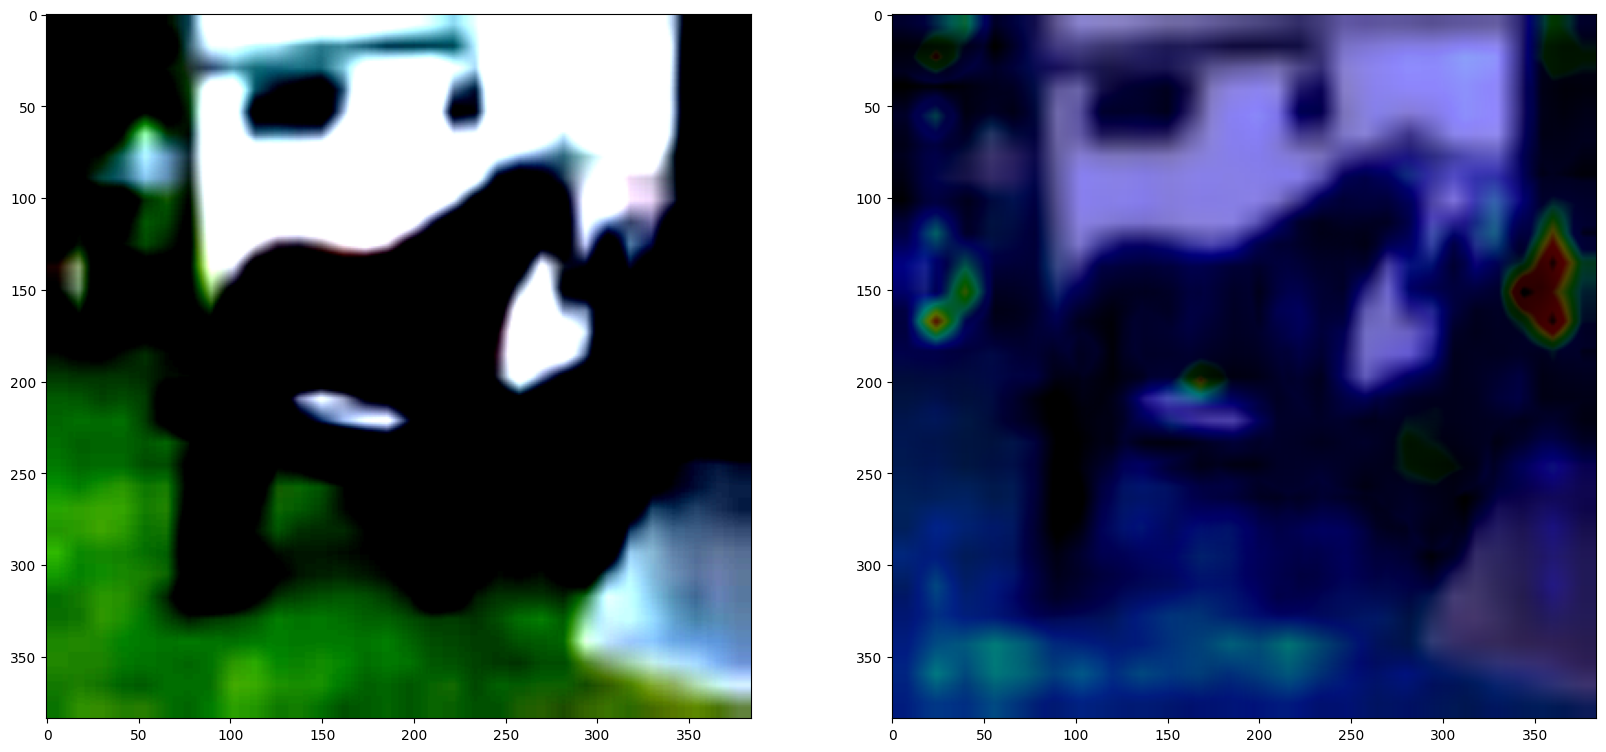

In [48]:
idx=20
show_mask_on_image(images_to_list[idx], masks[idx], 24, 16, 24*16)